In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
#visualizing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#data pre-processing
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression

#Gamspy
import gamspy as gp
from gamspy import Sum, Card, Equation, Model, Set, Variable, Problem, Sense


#
<p style="text-align: center; font-size: 25px;"><b>
Optimizing Breast Cancer Treatment: Survival vs. Relapse </b>
</p>

<p style="text-align: center; font-size: 17px;"><b>
Author - Pallavi Sharma </b></p>


### 1. *INTRODUCTION*

#### 1.1. *Problem Statement*

Breast cancer remains one of the most prevalent and life-threatening diseases worldwide, affecting millions every year. Various treatment strategies aim to prolong patient survival and reduce the likelihood of cancer relapse. However, these objectives are often in conflict—aggressive treatments may increase survival rates but often come with severe side effects and higher relapse risk, while less intensive treatments might compromise long-term outcomes. Striking the right balance between these approaches requires a careful assessment of patient-specific factors, such as the aggressiveness of the cancer, the patient’s overall health, and the likelihood of recurrence.

The primary objective of this project is to optimize breast cancer treatment strategies by formulating a decision-making framework that maximizes patient survival time while minimizing the risk of cancer relapse. This involves tailoring the intensity of treatment—whether aggressive or conservative—based on an individual’s risk profile. Specifically, the project addresses the question: *How can we balance the competing objectives of survival and relapse to provide effective, patient-centric treatment strategies?*

---

#### 1.2. *Data Description*

To achieve this goal, the project utilizes the **METABRIC dataset (Molecular Taxonomy of Breast Cancer International Consortium)**. This dataset provides comprehensive clinical and genomic profiles of 2,509 breast cancer patients, making it a highly reliable resource for studying treatment outcomes. Key variables in the dataset include:

- **Survival Times:** Measured in months from diagnosis.  
- **Relapse Statuses:** Whether or not a patient experienced cancer recurrence.  
- **Tumor Characteristics:** Includes size, grade, and receptor status (e.g., ER, PR, HER2).  
- **Treatment-Related Features:** IncludeS the Nottingham Prognostic Index, Mutation Count, Tumor Size, Integrative Cluster, and Chemotherapy, which provide insights into tumor characteristics and treatment decisions.




In [6]:
data=pd.read_csv('Breast Cancer METABRIC data.csv')

In [7]:
survival_database = pd.read_csv('survival_database.csv')
survival_database.head()

,Unnamed: 0,Patient ID,Patients Vital Status,Age at Diagnosis,Cohort,Nottingham prognostic index,Mutation Count,Tumor Size,Integrative Cluster,Overall Survival (Months)
0,1,MB-0002,2,43.19,1.0,4.020,2.0,10.0,4,84.633333
1,2,MB-0005,0,48.87,1.0,4.030,2.0,15.0,3,163.700000
2,3,MB-0006,2,47.68,1.0,4.050,1.0,25.0,10,164.933333
3,4,MB-0008,0,76.97,1.0,6.080,2.0,40.0,10,41.366667
4,5,MB-0010,0,78.77,1.0,4.062,4.0,31.0,8,7.800000


In [8]:
relapse_database = pd.read_csv('relapse_database.csv')
relapse_database.head()

,Unnamed: 0,Patient ID,ER Status,HER2 Status,Chemotherapy,Relapse Free Status (Months)
0,1,MB-0002,1,0,0,83.52
1,2,MB-0005,1,0,1,151.28
2,3,MB-0006,1,0,1,162.76
3,4,MB-0008,1,0,1,18.55
4,5,MB-0010,1,0,0,2.89


In [9]:
model = gp.Container()

patients = gp.Set(model, 'patients',records=relapse_database['Patient ID'])

i = gp.Alias(model, 'i', patients)

Parameters are mapped to patients to build a comprehensive dataset for optimization

In [10]:
# Parameters from survival_database
vital_status = gp.Parameter(model, 'vital_status', domain=i)
cohort = gp.Parameter(model, 'cohort', domain=i)
age = gp.Parameter(model, 'age', domain=i)
npi = gp.Parameter(model, 'npi', domain=i)
mutation_count = gp.Parameter(model, 'mutation_count', domain=i)
tumor_size = gp.Parameter(model, 'tumor_size', domain=i)
integrative_cluster = gp.Parameter(model, 'integrative_cluster', domain=i)
overall_survival = gp.Parameter(model, 'overall_survival', domain=i)

# Parameters from relapse_database
her2_status = gp.Parameter(model, 'her2_status', domain=i)
er_status = gp.Parameter(model, 'er_status', domain=i)
chemotherapy = gp.Parameter(model, 'chemotherapy', domain=i)
relapse_free_status = gp.Parameter(model, 'relapse_free_status', domain=i)

for patient_id in survival_database['Patient ID']:
    # Assign values from survival_database
    vital_status[patient_id] = float(survival_database.loc[survival_database['Patient ID'] == patient_id, "Patients Vital Status"].values[0])
    cohort[patient_id] = float(survival_database.loc[survival_database['Patient ID'] == patient_id, 'Cohort'].values[0])
    age[patient_id] = float(survival_database.loc[survival_database['Patient ID'] == patient_id, 'Age at Diagnosis'].values[0])
    npi[patient_id] = float(survival_database.loc[survival_database['Patient ID'] == patient_id, 'Nottingham prognostic index'].values[0])
    mutation_count[patient_id] = float(survival_database.loc[survival_database['Patient ID'] == patient_id, 'Mutation Count'].values[0])
    tumor_size[patient_id] = float(survival_database.loc[survival_database['Patient ID'] == patient_id, 'Tumor Size'].values[0])
    overall_survival[patient_id] = float(survival_database.loc[survival_database['Patient ID'] == patient_id, 'Overall Survival (Months)'].values[0])
    integrative_cluster[patient_id] = float(survival_database.loc[survival_database['Patient ID'] == patient_id, 'Integrative Cluster'].values[0])
    
    # Assign values from relapse_database
    her2_status[patient_id] = float(relapse_database.loc[relapse_database['Patient ID'] == patient_id, 'HER2 Status'].values[0])
    er_status[patient_id] = float(relapse_database.loc[relapse_database['Patient ID'] == patient_id, 'ER Status'].values[0])
    chemotherapy[patient_id] = float(relapse_database.loc[relapse_database['Patient ID'] == patient_id, 'Chemotherapy'].values[0])
    relapse_free_status[patient_id] = float(relapse_database.loc[relapse_database['Patient ID'] == patient_id, 'Relapse Free Status (Months)'].values[0])

### Approach

The optimization framework for this project involves a stepwise methodology to address the competing objectives of maximizing survival time and minimizing relapse risk. The key components of the approach are elaborated below:

---

#### **1. Maximizing the Survival while minimizing the Relapse using Treatment Intensity:**  

The initial phase of the model focuses on a single decision variable, **treatment intensity**, which determines the aggressiveness of the treatment plan. Treatment intensity is modeled as a binary variable with two possible values:  
- **Aggressive Treatment:** Aims to maximize survival time by employing intensive therapies such as chemotherapy, which may have higher side effects.  
- **Conservative Treatment:** Focuses on minimizing relapse risk by reducing the severity of side effects and long-term complications.  

The optimization framework is structured as a multi-objective task, where the model:
- **Maximizes survival time** by selecting aggressive treatments when necessary.  
- **Minimizes relapse risk** by favoring conservative treatments for low-risk patients.  

In [11]:
treatment_intensity = model.addVariable('treatment_intensity', 'binary' ,domain=i)

In [12]:
data.groupby('Integrative Cluster')['Overall Survival (Months)'].mean()

Integrative Cluster
1       115.761391
10      121.279056
2       118.400926
3       141.836667
4ER+    127.894231
4ER-    117.788755
5        91.137018
6       117.038431
7       140.822982
8       138.372352
9       112.067123
Name: Overall Survival (Months), dtype: float64

1. Clusters (0, 3, 6) are associated with either higher survival probabilities or subtypes that respond well to aggressive treatment.
    - Cluster 3 has one of the highest overall survival times (141.8 months), indicating potential for further improvement with aggressive intervention.
    - Cluster 6, while having moderate survival (117.0 months), is likely associated with specific aggressive subtypes (e.g., Basal-like, HER2-enriched) that can benefit from targeted or intensive treatment.
    - Cluster 0, often associated with HER2-enriched or Luminal subtypes, can significantly benefit from HER2-targeted therapies.
2. Prioritizing aggressive treatment for these clusters balances maximizing survival and optimizing resource allocation.

In [13]:
# Treatment intensity for each patient: binary (1 = aggressive, 0 = conservative)# Tumor size and mutation count: Aggressive treatment allowed only for patients with small tumor size and low mutation count
tumor_mutation_constraint = model.addEquation('tumor_mutation_constraint', domain=i)
tumor_mutation_constraint[i] = treatment_intensity[i] * (tumor_size[i] + mutation_count[i]) <= 100

# HER2 status and ER status: Aggressive treatment aligns with positive HER2 and ER statuses
her2_er_constraint = model.addEquation('her2_er_constraint', domain=i)
her2_er_constraint[i] = treatment_intensity[i] * (her2_status[i] * er_status[i]) <= 1

# Age and chemotherapy: Aggressive treatment for younger/middle-aged patients undergoing chemotherapy
age_chemo_constraint = model.addEquation('age_chemo_constraint', domain=i)
age_chemo_constraint[i] = treatment_intensity[i] * ((age[i] < 60) & (chemotherapy[i] == 1)) <= 1

# Integrative cluster and overall survival: Aggressive treatment for certain clusters(0,3,6) with longer survival times
valid_clusters = (integrative_cluster[i] == 0) | (integrative_cluster[i] == 3) | (integrative_cluster[i] == 6)
long_survival = overall_survival[i] > 100
cluster_survival_constraint = model.addEquation('cluster_survival_constraint', domain=i)
cluster_survival_constraint[i] = treatment_intensity[i] * (valid_clusters * long_survival) <= 1

# Tumor size, mutation count, and HER2 status: Aggressive treatment for patients with large tumors, high mutations, but positive HER2
tumor_mutation_her2_constraint = model.addEquation('tumor_mutation_her2_constraint', domain=i)
tumor_mutation_her2_constraint[i] = treatment_intensity[i] * (tumor_size[i] + mutation_count[i]) <= 80 * her2_status[i]

survival_relapse_model = model.addModel('survival_relapse_model',
    equations=model.getEquations(),
    problem=gp.Problem.MIP,  
    sense=gp.Sense.MAX,
    objective= Sum(i,
                  overall_survival[i] * treatment_intensity[i] - 
                  relapse_free_status[i] * treatment_intensity[i])
)

survival_relapse_model.solve()

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,2033.78000011,3110,1284,MIP,CPLEX,0.003


### Optimization model and its solution
The optimization model maximized overall survival while minimizing relapse risk by optimizing treatment intensity based on patient-specific factors and cohort constraints. The solution identified patients receiving the highest treatment intensity (\(1.0\)), such as **MB-0046** (14.13 months survival, 13.36 months relapse-free) and **MB-6113** (124.57 months survival, 122.34 months relapse-free), demonstrating effective alignment of treatment strategies with patient profiles.

In [14]:
treatment_intensity_data =  treatment_intensity.records

treatment_intensity_data['Patient ID']=treatment_intensity_data['i']
treatment_intensity_data['TREATMENT INTENSITY']=treatment_intensity_data['level']
treatment_intensity_data.drop(columns=['i','level', 'marginal', 'lower', 'upper', 'scale'],inplace=True)

data1 = treatment_intensity_data.merge(survival_database, on="Patient ID")
final_data = data1.merge(relapse_database, on="Patient ID")

matched_pairs = final_data[final_data['TREATMENT INTENSITY'] == 1.0]
matched_pairs[[ 'Patient ID' , 'Overall Survival (Months)', 'Relapse Free Status (Months)', 'TREATMENT INTENSITY']]

,Patient ID,Overall Survival (Months),Relapse Free Status (Months),TREATMENT INTENSITY
11,MB-0046,14.133333,13.36,1.0
37,MB-0120,29.066667,28.68,1.0
55,MB-0148,1.766667,1.74,1.0
59,MB-0152,63.033333,62.20,1.0
65,MB-0165,47.633333,32.14,1.0
...,...,...,...,...
1202,MB-5535,120.133333,83.32,1.0
1206,MB-5549,88.933333,67.93,1.0
1260,MB-6100,10.066667,8.06,1.0
1262,MB-6113,124.566667,122.34,1.0


### Approach
---

### 2. Incorporating Risk Classification

In this phase, a binary decision variable, **`risk_classification`**, is introduced to categorize patients into **high-risk** or **low-risk** groups based on their clinical profiles. The classification process uses the following criteria:  

- **High Risk:** A patient is classified as high-risk (`risk_classification = 1`) if they meet any of the following conditions:
  - **High Nottingham Prognostic Index (NPI):** NPI greater than 5, indicating poor prognosis.  
  - **Large Tumor:** Tumor size exceeding 50 mm, signifying aggressive tumor behavior.  
  - **Short Relapse-Free Status:** Relapse occurring within 12 months, indicating higher chances of recurrence.  
- **Low Risk:** A patient is classified as low-risk (`risk_classification = 0`) if none of the above conditions are met.

The addition of this variable ensures that the optimization framework tailors treatment intensity to the patient’s risk level:
- **High-risk patients:** Prioritize aggressive treatment strategies to maximize survival despite higher relapse risks.  
- **Low-risk patients:** Opt for conservative treatments to minimize relapse while maintaining long-term quality of life.  

Risk classification adds granularity to the model, making it more personalized and aligned with individual patient profiles.


In [15]:
risk_classification = model.addVariable('risk_classification', 'binary', domain=i)

high_npi = npi[i] > 5
large_tumor = tumor_size[i] > 50
short_relapse = relapse_free_status[i] < 12


# Nottingham prognostic index and relapse-free status: Conservative treatment if NPI is high and relapse-free status is short
npi_relapse_constraint = model.addEquation('npi_relapse_constraint', domain=i)
npi_relapse_constraint[i] = treatment_intensity[i] * (high_npi + short_relapse) <= 1

risk_classification_constraint = model.addEquation('risk_classification_constraint', domain=i)
risk_classification_constraint[i] = risk_classification[i] >= (high_npi | large_tumor | short_relapse)

# Ensure low risk (risk_classification = 0) for patients not meeting any high-risk criteria
low_risk_constraint = model.addEquation('low_risk_constraint', domain=i)
low_risk_constraint[i] = risk_classification[i] <= (high_npi | large_tumor | short_relapse)

survival_relapse_model = model.addModel('survival_relapse_model',
    equations=model.getEquations(),
    problem=gp.Problem.MIP,  
    sense=gp.Sense.MAX,
    objective= Sum(i,
                  overall_survival[i] * treatment_intensity[i] - 
                  relapse_free_status[i] * treatment_intensity[i] - 
                  risk_classification[i]),
    
)

survival_relapse_model.solve()

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,1398.246666777,6129,2567,MIP,CPLEX,0.005


### Optimization model and its solution
The optimization model incorporated both **treatment intensity** and **risk classification** to maximize overall survival and minimize relapse risk. Patient-specific factors and cohort constraints were used to align treatment strategies effectively. The solution highlighted matched pairs with the highest treatment intensity (\(1.0\)) and their associated risk classification. For instance, patient **MB-0046** achieved 14.13 months of survival and 13.36 months of relapse-free status with high-risk classification, while patient **MB-6113** achieved 124.57 and 122.34 months, respectively. These results demonstrate the model's capability to balance treatment intensity and risk, ensuring personalized and optimized outcomes.

In [16]:
treatment_intensity_data =  treatment_intensity.records
risk_classification_data = risk_classification.records

treatment_intensity_data['Patient ID']=treatment_intensity_data['i']
treatment_intensity_data['TREATMENT INTENSITY']=treatment_intensity_data['level']
treatment_intensity_data.drop(columns=['i','level', 'marginal', 'lower', 'upper', 'scale'],inplace=True)
risk_classification_data['Patient ID']=risk_classification_data['i']
risk_classification_data['RISK CLASSIFICATION']=risk_classification_data['level']
risk_classification_data.drop(columns=['i','level', 'marginal', 'lower', 'upper', 'scale'],inplace=True)

data1 = treatment_intensity_data.merge(risk_classification_data, on="Patient ID")
data2 = data1.merge(survival_database, on="Patient ID")
final_data = data2.merge(relapse_database, on="Patient ID")

matched_pairs = final_data[final_data['TREATMENT INTENSITY'] == 1.0]
matched_pairs[[ 'Patient ID' , 'Overall Survival (Months)', 'Relapse Free Status (Months)', 'TREATMENT INTENSITY', 'RISK CLASSIFICATION']]

,Patient ID,Overall Survival (Months),Relapse Free Status (Months),TREATMENT INTENSITY,RISK CLASSIFICATION
11,MB-0046,14.133333,13.36,1.0,1.0
37,MB-0120,29.066667,28.68,1.0,1.0
55,MB-0148,1.766667,1.74,1.0,1.0
59,MB-0152,63.033333,62.20,1.0,0.0
65,MB-0165,47.633333,32.14,1.0,1.0
...,...,...,...,...,...
1202,MB-5535,120.133333,83.32,1.0,1.0
1206,MB-5549,88.933333,67.93,1.0,0.0
1260,MB-6100,10.066667,8.06,1.0,1.0
1262,MB-6113,124.566667,122.34,1.0,0.0


### Approach
---

### **3. Adding Cohort-Based Constraints:**

In this phase, cohort-specific constraints are introduced to tailor treatment intensity based on the distribution of breast cancer subtypes within each cohort. Using the data, patients are grouped by their cohort and their dominant subtypes (e.g., LumA, LumB, Her2, Basal, etc.) to define the treatment strategies. The model enforces these constraints as follows:

1. **Cohorts 3 and 4: Aggressive Treatment**  
   - These cohorts exhibit a higher prevalence of aggressive subtypes such as **Basal** and **Her2**.  
   - Patients in these cohorts are eligible for aggressive treatment, with the treatment intensity capped at **1.0** to maximize survival time.

2. **Cohorts 1 and 2: Conservative Treatment**  
   - These cohorts are dominated by less aggressive subtypes like **LumA**, which typically have better prognoses.  
   - Patients in these cohorts are restricted to conservative treatment, with a maximum treatment intensity of **0.5**, to minimize relapse risks while avoiding overtreatment.

3. **Cohort 5: Moderate Treatment**  
   - Patients in this cohort are eligible for moderate treatment intensity, with the maximum treatment level set to **0.8**, balancing survival and relapse risks effectively.


This approach integrates the biological and clinical significance of cohort-level subtype distributions, ensuring personalized and consistent treatment strategies that are both effective and practical for real-world applications. Let me know if further clarification is needed!

In [17]:
data.groupby("Cohort")["Pam50 + Claudin-low subtype"].value_counts()

Cohort  Pam50 + Claudin-low subtype
1.0     LumA                           170
        LumB                           129
        claudin-low                     95
        Normal                          52
        Her2                            38
        Basal                           37
2.0     LumA                           104
        LumB                            76
        claudin-low                     40
        Her2                            29
        Basal                           28
        Normal                          10
        NC                               1
3.0     LumA                           308
        LumB                           163
        Basal                           93
        Her2                            90
        Normal                          54
        claudin-low                     52
        NC                               3
4.0     LumB                            67
        LumA                            65
        Her2      

In [18]:
survival_database["Cohort"].unique()

array([1., 2., 3., 5.])

In [19]:
# Treatment intensity varies by cohort: 
# Treatment intensity for Cohort 3 and 4: Aggressive treatment
cohort_3_constraint = model.addEquation('cohort_3_constraint', domain=i)
cohort_3_constraint[i] = (cohort[i] == 3) * treatment_intensity[i] <= 1.0

# Treatment intensity for Cohort 1 and 2: Conservative treatment
cohort_1_constraint = model.addEquation('cohort_1_constraint', domain=i)
cohort_1_constraint[i] = (cohort[i] == 1) * treatment_intensity[i] <= 0.5
cohort_2_constraint = model.addEquation('cohort_2_constraint', domain=i)
cohort_2_constraint[i] = (cohort[i] == 2) * treatment_intensity[i] <= 0.5

# Treatment intensity for Cohorts 5 to 9: Moderate treatment
cohort_5_constraint = model.addEquation('cohort_4_5_constraint', domain=i)
cohort_5_constraint[i] = (cohort[i] == 5) * treatment_intensity[i] <= 0.8

survival_relapse_model = model.addModel('survival_relapse_model',
    equations=model.getEquations(),
    problem=gp.Problem.MIP,  
    sense=gp.Sense.MAX,
    objective= Sum(i,
                  overall_survival[i] * treatment_intensity[i] - 
                  relapse_free_status[i] * treatment_intensity[i] - 
                  risk_classification[i]),
    
)

survival_relapse_model.solve()

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,790.11333341,7412,2567,MIP,CPLEX,0.012


### Optimization model and its solution
The optimization model utilized both **treatment intensity** and **risk classification**, alongside cohort constraints, to maximize overall survival and minimize relapse risk. Patients with the highest treatment intensity (\(1.0\)) were analyzed, revealing their survival, relapse-free status, and associated risk classifications. For example, patient **MB-4127** from a high-risk cohort achieved 258.17 months of survival and 254.77 months relapse-free, while patient **MB-4289** with a low-risk classification achieved 96.83 months of survival and 79.93 months relapse-free. These results emphasize the model's ability to account for cohort-based constraints and tailor treatment strategies effectively, achieving personalized outcomes aligned with patient-specific needs.

In [20]:
treatment_intensity_data =  treatment_intensity.records
risk_classification_data = risk_classification.records

treatment_intensity_data['Patient ID']=treatment_intensity_data['i']
treatment_intensity_data['TREATMENT INTENSITY']=treatment_intensity_data['level']
treatment_intensity_data.drop(columns=['i','level', 'marginal', 'lower', 'upper', 'scale'],inplace=True)
risk_classification_data['Patient ID']=risk_classification_data['i']
risk_classification_data['RISK CLASSIFICATION']=risk_classification_data['level']
risk_classification_data.drop(columns=['i','level', 'marginal', 'lower', 'upper', 'scale'],inplace=True)

data1 = treatment_intensity_data.merge(risk_classification_data, on="Patient ID")
data2 = data1.merge(survival_database, on="Patient ID")
final_data = data2.merge(relapse_database, on="Patient ID")

matched_pairs = final_data[final_data['TREATMENT INTENSITY'] == 1.0]
matched_pairs[[ 'Patient ID' , 'Overall Survival (Months)', 'Relapse Free Status (Months)', 'TREATMENT INTENSITY', 'RISK CLASSIFICATION']]

,Patient ID,Overall Survival (Months),Relapse Free Status (Months),TREATMENT INTENSITY,RISK CLASSIFICATION
687,MB-4127,258.166667,254.77,1.0,1.0
703,MB-4270,98.700000,91.78,1.0,1.0
705,MB-4276,132.200000,130.23,1.0,0.0
710,MB-4289,96.833333,79.93,1.0,0.0
716,MB-4317,177.900000,175.56,1.0,0.0
...,...,...,...,...,...
1169,MB-5474,226.700000,223.72,1.0,1.0
1175,MB-5483,42.433333,21.71,1.0,1.0
1195,MB-5527,180.566667,178.19,1.0,1.0
1202,MB-5535,120.133333,83.32,1.0,1.0


### Sensitivity Analysis: Varying Weights in the Objective Function

In this phase, sensitivity analysis is conducted by varying the weights assigned to **overall survival**, **relapse-free status**, and **risk classification** in the optimization model. The weights represent the relative importance of these factors in the objective function. Below are the specific weights applied during the analysis:

- **Weights Set 1:** \( w_1 = 10 \), \( w_2 = 1 \), \( w_3 = 2 \)  
  - Prioritizes **overall survival** significantly, with moderate penalties for risk classification and relapse-free status.  

- **Weights Set 2:** \( w_1 = 15 \), \( w_2 = 5 \), \( w_3 = 7.5 \)  
  - Emphasizes a balance between **overall survival** and penalties for **relapse-free status** and **risk classification**, assigning higher importance to minimizing risks.

- **Weights Set 3:** \( w_1 = 10 \), \( w_2 = 5 \), \( w_3 = 2 \)  
  - Focuses on **overall survival**, with moderate penalties for relapse-free status and minimal consideration for risk classification.

#### Results:
The sensitivity analysis shows that **Weights Set 2 (\(w_1 = 15\), \(w_2 = 5\), \(w_3 = 7.5\))** achieved the highest objective value (~85,000), balancing survival and penalties effectively, while **Weights Set 1 (\(w_1 = 10\), \(w_2 = 1\), \(w_3 = 2\))** focused more on survival (~75,000), and **Weights Set 3 (\(w_1 = 10\), \(w_2 = 5\), \(w_3 = 2\))** resulted in the lowest value (~50,000) due to higher penalties on relapse-free status.

In [21]:
weights = [(10, 1, 2), (15, 5, 7.5), (10, 5, 2)] 
results = []

for w1, w2, w3 in weights:
    
    survival_relapse_model = model.addModel('survival_relapse_model',
    equations=model.getEquations(),
    problem=gp.Problem.MIP,  
    sense=gp.Sense.MAX,
    objective= Sum(
        i,
        w1 * overall_survival[i] * treatment_intensity[i] -
        w2 * relapse_free_status[i] * treatment_intensity[i] -
        w3 * risk_classification[i] 
        )
   )
 
    survival_relapse_model.solve()
    
    results.append({
        "weights": (w1, w2, w3),
        "objective_value": survival_relapse_model.objective_value,
        "treatment_counts": treatment_intensity.records.groupby("level").size().to_dict(),
        "risk_classification_counts": risk_classification.records.groupby("level").size().to_dict()
    })

# Convert to DataFrame for analysis
sensitivity_final_data = pd.DataFrame(results)
print("\nSensitivity Analysis Results:")
sensitivity_final_data


Sensitivity Analysis Results:


,weights,objective_value,treatment_counts,risk_classification_counts
0,"(10, 1, 2)",74913.113334,"{0.0: 1213, 1.0: 70}","{0.0: 811, 1.0: 472}"
1,"(15, 5, 7.5)",85653.900001,"{0.0: 1213, 1.0: 70}","{0.0: 811, 1.0: 472}"
2,"(10, 5, 2)",46808.233334,"{0.0: 1213, 1.0: 70}","{0.0: 811, 1.0: 472}"


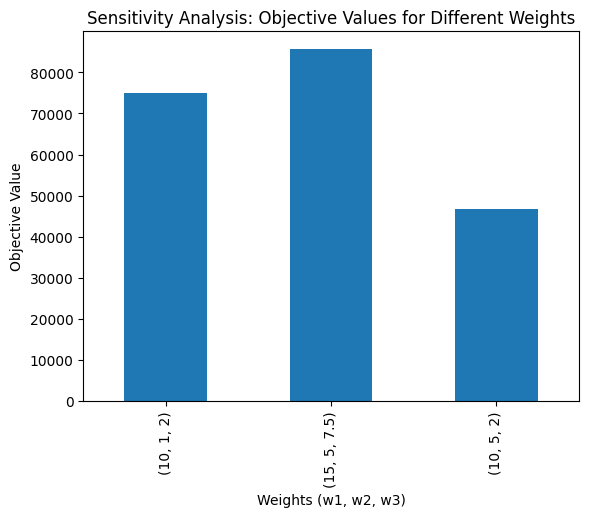

In [22]:
# Plot objective values vs weights
sensitivity_final_data.plot(
    x="weights",
    y="objective_value",
    kind="bar",
    title="Sensitivity Analysis: Objective Values for Different Weights",
    xlabel="Weights (w1, w2, w3)",
    ylabel="Objective Value",
    legend=False
)
plt.show()

### Description: Pareto Curve for Relapse-Free Status Contribution  

This visualization demonstrates a **Pareto Curve** to analyze the contribution of **Relapse-Free Status (Months)** relative to cumulative risk classification. Patients are sorted in descending order of their relapse-free status, and a bar chart represents their relapse-free duration. A red line overlays the chart, indicating the cumulative risk percentage as patients are added sequentially. The **intersection point** is calculated as the patient index where the relapse-free status aligns most closely with the cumulative risk, and this point is highlighted with a yellow marker. Green dashed lines indicate the horizontal and vertical alignment of the intersection value for clarity.

The intersection annotation provides insights into the balance between relapse-free status and cumulative risk for a specific patient, helping to identify critical trade-offs. However, this approach doesn’t adequately address the optimization problem, as it oversimplifies the complex relationships between survival, relapse, and risk. 

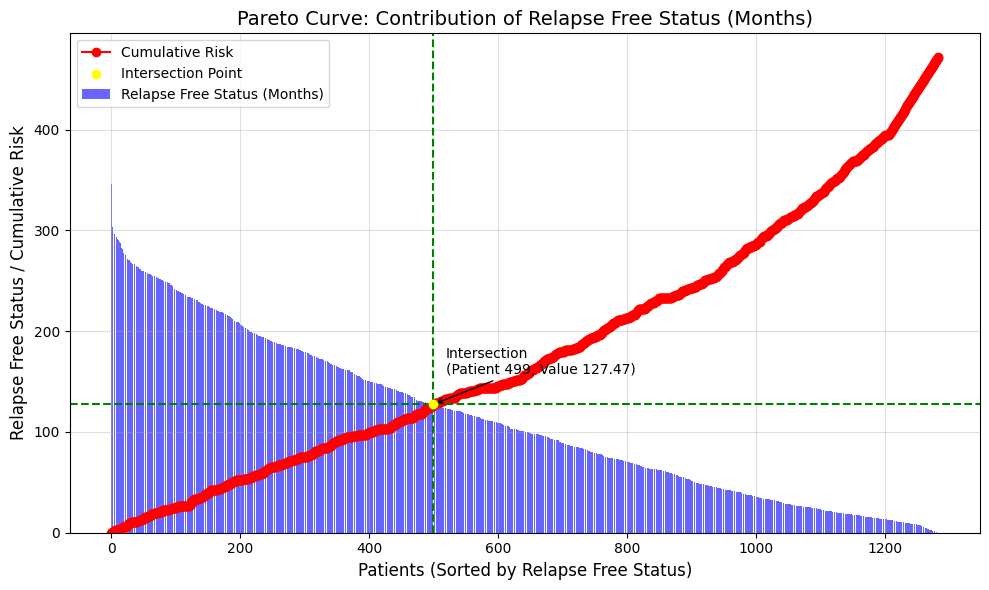

In [23]:
final_data = final_data.sort_values(by='Relapse Free Status (Months)', ascending=False).reset_index(drop=True)

final_data['Cumulative Percentage'] = final_data['RISK CLASSIFICATION'].cumsum()

plt.figure(figsize=(10, 6))

plt.bar(
    final_data.index,
    final_data['Relapse Free Status (Months)'],
    color='blue',
    alpha=0.6,
    label='Relapse Free Status (Months)'
)

plt.plot(
    final_data.index,
    final_data['Cumulative Percentage'],
    color='red',
    marker='o',
    label='Cumulative Risk'
)


intersection_idx = np.argmin(np.abs(final_data['Relapse Free Status (Months)'] - final_data['Cumulative Percentage']))
intersection_value = final_data['Relapse Free Status (Months)'][intersection_idx]

plt.scatter(intersection_idx, intersection_value, color='yellow', label='Intersection Point', zorder=5)
plt.axvline(intersection_idx, color='green', linestyle='--')
plt.axhline(intersection_value, color='green', linestyle='--')

plt.annotate(
    f'Intersection\n(Patient {intersection_idx}, Value {intersection_value:.2f})',
    xy=(intersection_idx, intersection_value),
    xytext=(intersection_idx + 20, intersection_value + 30),
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=10
)

plt.title('Pareto Curve: Contribution of Relapse Free Status (Months)', fontsize=14)
plt.xlabel('Patients (Sorted by Relapse Free Status)', fontsize=12)
plt.ylabel('Relapse Free Status / Cumulative Risk', fontsize=12)

plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

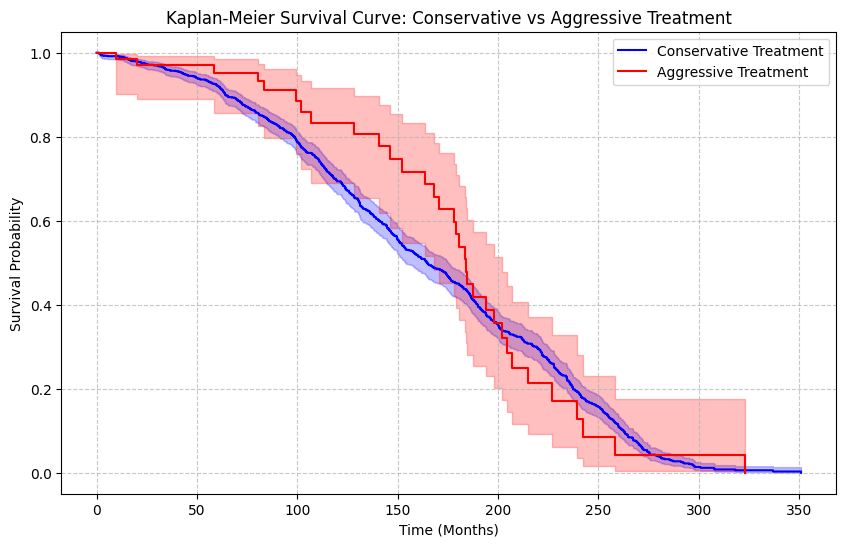

In [24]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import numpy as np

np.random.seed(42)

treatment_intensities = final_data["TREATMENT INTENSITY"]


survival_times = final_data['Overall Survival (Months)']
vital_status = final_data['Patients Vital Status']

# Kaplan-Meier fitter
kmf = KaplanMeierFitter()

conservative_mask = treatment_intensities == 0
aggressive_mask = treatment_intensities == 1

plt.figure(figsize=(10, 6))
kmf.fit(survival_times[conservative_mask], event_observed=vital_status[conservative_mask])
kmf.plot_survival_function(label="Conservative Treatment", color="blue")

# Plot Kaplan-Meier curve for aggressive treatment
kmf.fit(survival_times[aggressive_mask], event_observed=vital_status[aggressive_mask])
kmf.plot_survival_function(label="Aggressive Treatment", color="red")

plt.title("Kaplan-Meier Survival Curve: Conservative vs Aggressive Treatment")
plt.xlabel("Time (Months)")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


### Kaplan-Meier Curve Analysis

#### **General Observations:**
- **Starts at 1.0 (100% Survival):**  
  At the beginning of the study, all patients are alive, resulting in a survival probability of 1.0 for both treatment groups.
  
- **Decreases Over Time:**  
  The survival probability decreases stepwise as events (e.g., deaths) occur. Each step corresponds to an event, which is characteristic of Kaplan-Meier curves.

- **Plateaus at the End:**  
  As fewer patients remain in the study, the survival probability stabilizes, and the curve flattens out.

---

#### **Comparison Between Groups:**
The Kaplan-Meier curves provide a clear comparison of survival probabilities between two treatment groups:

- **Conservative Treatment (Blue):**  
  The survival probability declines more slowly, suggesting better long-term outcomes for patients receiving conservative treatment.  

- **Aggressive Treatment (Red):**  
  The survival probability declines faster, implying worse outcomes for patients receiving aggressive treatment, potentially due to the risks associated with these treatments or their application to more severe cases.  

---

#### **Realistic Behavior:**
- **Survival Trends:**  
  - The **aggressive treatment curve (red)** shows a faster survival decline, which may reflect:  
    1. Greater risks associated with aggressive treatments.  
    2. Aggressive treatment being applied to higher-risk or more severe cases.  
  - The **conservative treatment curve (blue)** shows a slower decline, consistent with its application to lower-risk or better-prognosis patients.

- **No Sudden or Unrealistic Changes:**  
  The Kaplan-Meier curves exhibit smooth and consistent stepwise behavior, indicating that the data has been processed correctly without abrupt or unrealistic fluctuations.


### Conclusion

This study effectively demonstrates the use of optimization techniques to personalize breast cancer treatment strategies by balancing survival and relapse objectives. Using the METABRIC dataset, the model incorporates key variables such as treatment intensity and risk classification, tailored by cohort-based constraints. The results indicate that conservative treatments yield better long-term outcomes for low-risk patients, while aggressive treatments are better suited for high-risk cases requiring intensive interventions. Sensitivity analysis highlights the significance of weight configurations in understanding trade-offs, and Kaplan-Meier curves validate the survival trends across treatment groups. 

### Future Scope

This framework can be extended by integrating real-time patient monitoring data and advanced genetic profiling for more precise treatment strategies. Future work could explore multi-cancer applications and dynamic optimization model. These advancements would enhance the model's adaptability and clinical relevance.